Imports

In [1]:
import torch
import numpy as np
import pandas as pd
import os
from os import listdir
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
#import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
# %matplotlib inline
#import imutils

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle #shuffling the data improves the model
import warnings

SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
#torch.cuda.manual_seed_all(SEED)
warnings.filterwarnings("ignore", "Lazy modules are a new feature.*")

from torch import nn,optim
from torchvision import transforms as T,datasets,models
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from collections import OrderedDict
from tqdm import tqdm
pd.options.plotting.backend = "plotly"
from torch.autograd import Variable
from torchvision.utils import save_image
import torchsummary
#from torchvision import imshow
# import cleanlab
# from cleanlab.classification import CleanLearning
# from cleanlab.benchmarking import noise_generation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from numpy.random import multivariate_normal
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from matplotlib.image import imread
import seaborn as sns
import random
#import cv2
import copy
from sklearn.model_selection import train_test_split
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from torch.utils.data.sampler import SubsetRandomSampler  # For validation set


ALED Stuff

In [126]:
import sklearn
from sklearn.covariance import MinCovDet

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
import scipy.stats

class ALED(sklearn.base.BaseEstimator, sklearn.base.ClassifierMixin):
    # BaseEstimator provides get and set_params() functions and ClassifierMixin provides weighted accuracy

    def __init__(self, random_state = 0): # random_state is default 0 for now, should be changed later!
        # Note: I think the sklearn API would say that some fit() params [e.g., model, max_pca_components, max_pca_variance]
        #   should be instantiation params and not fit() params

        self.random_state = random_state

    @staticmethod
    def sum_until(in_list, threshold):
        """
        Helper function for fit()
        """
        count = 0
        for n in range(len(in_list)):
            if count < threshold:
                count += in_list[n]
            else:
                break
        return count, n+1

    @staticmethod
    def gaussian_likelihood(cov_matrix, mahalanobis_squared_dist):
        """
        Helper function for fit()
        """
        n = cov_matrix.shape[0]
        sqrt_det = np.sqrt(np.linalg.det(cov_matrix))
        prob_x_f = ( 1 / ( (2*np.pi)**(n/2) * sqrt_det ) ) * np.exp(-0.5*mahalanobis_squared_dist)
        #if prob_x_f > 1: print("prob_x_f > 1; prob_x_f =", prob_x_f)
        return prob_x_f

    def extract_conv_net_features(self, conv_net, dataset):
        """
        Helper function for fit()
        """
        pass

    def map_conv_net_output(self):
        """
        Map the last layer of the convolutional layer (or other last feature extraction layer)
        so each sample ends up with 1 dimension of representative features
        """
        pass


    def extract_out_label(self, prediction_stats_row):
        given_label = prediction_stats_row['given label (name)']
        probabilities_row = np.array([prediction_stats_row["p(k = {} | x)".format(class_i)] for class_i in self.classes_])
        if (self.classes_[probabilities_row.argmax()] != given_label)\
           and (probabilities_row.max()/prediction_stats_row["p(k = {} | x)".format(given_label)] > self.likelihood_ratio_threshold):
            return self.classes_[probabilities_row.argmax()]
        else:
            return given_label

    def fit_predict(self, model, dataset, device=None, max_pca_components=10, max_pca_variance=0.25, likelihood_ratio_threshold=2, prob_method="gaussian", batch_size=100):
        # sklearn would want us to separate into fit() and predict() (NR)
        """
        Given a model and data, outputs predicted class for each sample based on ALED algorithm.
        Creates a new model that aggregates input classification model features / feature maps at last layer before classification into a [p x 1] vector.
        Then performs PCA to generate an [n x 1] vector of PCs, where n is specified either explicitly or by a desired level of explained variance. Then
        the probability that a given sample belongs to the assigned class is assessed using Bayes' rule, and if the probability falls below the within
        class threshold, then the sample is compared to the other class(es), and if the probability that it belongs in another class is higher than the
        out of class threshold, then the sample is added to an output DataFrame containing suspect samples and their associated probabilities. This
        function is dependent on the ability of the input classification model to extract salient features from the input data and thus should only be
        applied if the model is achieving some threshold auc / accuracy.

        ### Parameters
        1. model : Pytorch model (torch.nn.Sequential)
            -A classification model
        2. dataset : Pytorch Dataset (torch.utils.data.Dataset, eventually...right now needs an ImageFolder)
            -The dataset used to train model
             note: the dataset is responsible for holding any transformation functions;
             the transformations need to be the same transformations done for model evaluation; data augmentation should NOT be used!!!
        x. device : str, or None
            -Specifies device (e.g. 'cuda' GPU) to be used for processing
        4. max_pca_components : int
            -Maximum number of components used for PCA (10 by default);
             determines
        5. pca_variance : float
            -Ratio of explained variance desired, if
             using explained variance method (0.25 by
             default)
        6. wc_threshold : float
            -Within class threshold to consider sample
             within distribution of other class(es) (0.05
             by default)
        7. ooc_threshold : float
            -Out of class threshold to see whether flagged
             samples belong to other class(es) (0.95 by
             default)
        8. prob_method : str
            -Method to use for calculating the likelihood,
             either specify a distribution type or use a
             non-parametric estimator ("gaussian" is
             default)
        9. data_transforms : func
            -Any data transformations performed prior to use
             by the model # specify torchvision transforms (NR)

        ### Returns
        1. label_issues_df : Pandas DataFrame (pd.DataFrame)
            -A DataFrame containing the samples that are
             suspected label errors and their associated
             probabilities of belonging to each class,
             as calculated by the above methods

        ### Raises
        ______
        We'll get to that

        ### object attributes created:
        - self.conv_net
        - self.X_
        - self.y_
        - self.classes_
        - self.pca
        - self.num_pca_components
        - self.pca_explained_variance
        - self.X_pca_tf
        - self.c
        - self.prediction_stats

        """
        # Define Adaptive Labeling Error Detection (ALED) feature extraction model
        # I changed "ALED_model" to "self.conv_net"; please don't kill me; I think CNN, conv_net, or FEM are better names (NR)
        self.conv_net = nn.Sequential(*list(copy.deepcopy(model).eval().children())[:-1])
        # self.conv_net
        # I think this^ won't work for all models; maybe we do a deep recursive dive into model.modules() or
        #    model.children() to identify the last layer of type conv (NR)

        self.conv_net.avgpool = torch.nn.AdaptiveAvgPool2d((1,1)) # Feature pooling of feature maps, probably will need to add another method for 1d and 3d features
        print(self.conv_net)
        # Create sorted representation of data (right now only works on images in chest x-ray dataset):

        BATCH_SIZE = batch_size # maybe a param?
        dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

        feat_array = None # will be initialized once we know size of
        y = np.zeros(len(dataset))
        with torch.no_grad():
            for batch_num, (inputs, labels) in enumerate(dataloader):
                # note: the dataset is responsible for holding any transformation functions;
                # the transformations need to be the same transformations done for model evaluation; data augmentation should NOT be used!!!

                batch_cuda = inputs.to(device)
                
                batch_feat = self.conv_net(batch_cuda)
                batch_feat_cpu = batch_feat.to('cpu').squeeze() # this might need to be changed - can we assume user wants to use 'cpu'?
                # return batch_feat_cpu
                if feat_array is None:
                    feat_array = np.zeros((len(dataset), *batch_feat_cpu.shape[1:]))

                feat_array[batch_num*BATCH_SIZE : batch_num*BATCH_SIZE + len(batch_feat_cpu)] = batch_feat_cpu
                y[         batch_num*BATCH_SIZE : batch_num*BATCH_SIZE + len(batch_feat_cpu)] = labels

                del batch_cuda
                del batch_feat

        # feat_array.squeeze()

        print("feat_array.shape, y.shape:", feat_array.shape, y.shape)
        # Check that X and y have correct shape
        feat_array, y = check_X_y(feat_array, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.X_ = feat_array
        self.y_ = y
#         self.sample_weights = sample_weight # might need sample_weight param for compatibility with sklearn - document if ignored

        # perform PCA
        from sklearn.decomposition import PCA
        self.pca = PCA(n_components = max_pca_components) # don't rename this - we overwrite this variable 3 lines later
        self.pca.fit(feat_array)
        calc_var, max_variance_num_comps = self.sum_until(self.pca.explained_variance_ratio_, max_pca_variance)
        self.pca = PCA(n_components = min(max_pca_components, max_variance_num_comps)).fit(feat_array)
        self.X_pca_tf = self.pca.transform(feat_array) # pca_tf means pca transformed

        # instead of PCA, consider sklearn.random_projection.GaussianRandomProjection - maybe more robust to noise (NR)
        # also, random_projection.johnson_lindenstrauss_min_dim(...) finds a 'safe' number of components to randomly project to.


        # optional (could be helpful for user):
        self.num_pca_components = self.pca.n_components_
        self.pca_explained_variance = calc_var
        print("number of pca components:", self.num_pca_components)
        print("PCA explained variance:", self.pca_explained_variance)

        # Calculate covariance matrices for all class distributions
        self.num_classes = len(self.classes_)
        self.class_indices_dict = {}
        self.priors_dict = {}
        self.PC_dict = {}
        self.cov_dict = {}
        self.mvn_distributions = {}

        for class_i in self.classes_:
            class_indices = np.array(np.arange(len(feat_array))[y == class_i])
            self.class_indices_dict["class{}_indices".format(class_i)] = class_indices
            class_PC_array = self.X_pca_tf[class_indices, :]
            self.PC_dict["class{}_PC_array".format(class_i)] = class_PC_array
            self.cov_dict["robust_cov{}".format(class_i)] = MinCovDet(random_state=self.random_state).fit(class_PC_array)
            # self.mvn_distributions["mvn_{}".format(class_i)] = scipy.stats.multivariate_normal(mean=class_PC_array.mean(axis=0), cov=np.cov(class_PC_array, rowvar=False), seed=self.random_state) # this line from chatgpt, so could be good to double check the cov matrix is right (NR)

        # Calculate prior probabilities
        for class_i in self.classes_:
            prior = len(self.class_indices_dict["class{}_indices".format(class_i)]) / len(y)
            self.priors_dict["prior_prob{}".format(class_i)] = prior

        # Calculate likelihoods
        likelihoods_df_dict = {}
        for class_i in self.classes_:
            likelihoods_dict = {}
            for class_j in self.classes_:
                cov_matrix = self.cov_dict["robust_cov{}".format(class_j)].covariance_ #raw_covariance_ # why do we use raw_covariance_ instead of covariance_? (NR)
                cov_mahalanobis = self.cov_dict["robust_cov{}".format(class_j)].mahalanobis(self.PC_dict["class{}_PC_array".format(class_i)]) # I think this was redundant; see MinCovDet.dist_ (NR)
                likelihoods_dict["p(x | k = {})".format(class_j)] = np.array([self.gaussian_likelihood(cov_matrix, sample) for sample in cov_mahalanobis])

                # mahalanobis_distances = self.cov_dict["robust_cov{}".format(class_j)].dist_
                # likelihoods_dict["p(x | k = {})".format(class_j)] = np.array([self.gaussian_likelihood(cov_matrix, sample**2) for sample in mahalanobis_distances])

                # likelihoods = self.mvn_distributions["mvn_{}".format(class_j)].pdf(self.PC_dict["class{}_PC_array".format(class_i)])
                # class_j_pca_tf = self.PC_dict["class{}_PC_array".format(class_j)]
                # likelihoods = scipy.stats.multivariate_normal.pdf(self.PC_dict["class{}_PC_array".format(class_i)], mean=class_j_pca_tf.mean(axis=0), cov=np.cov(class_j_pca_tf, rowvar=False))
                # likelihoods_dict["p(x | k = {})".format(class_j)] = likelihoods

            likelihoods_df = pd.DataFrame.from_dict(likelihoods_dict).set_index(self.class_indices_dict["class{}_indices".format(class_i)])
            likelihoods_df_dict["likelihood_df{}".format(class_i)] = likelihoods_df

        # Calculate probabilities
        final_dfs_list = []
        for class_i in self.classes_:
            likelihoods_df = likelihoods_df_dict["likelihood_df{}".format(class_i)]
            for class_j in self.classes_:
                likelihoods_df["p(k = {} | x)".format(class_j)] = likelihoods_df["p(x | k = {})".format(class_j)] * self.priors_dict["prior_prob{}".format(class_j)] / \
                    sum( [likelihoods_df["p(x | k = {})".format(class_k)] * self.priors_dict["prior_prob{}".format(class_k)] for class_k in self.classes_] )
#             likelihoods_df["given label (num)"] = n
            likelihoods_df["given label (name)"] = class_i
            # likelihoods_df["updated label (name)"] =
            final_dfs_list.append(likelihoods_df)

        self.prediction_stats = pd.concat(final_dfs_list).sort_index()
        self.likelihood_ratio_threshold = likelihood_ratio_threshold
        self.prediction_stats['Aled label'] = self.prediction_stats.apply(self.extract_out_label, axis=1)

        return self.prediction_stats['Aled label']

Dataset Setup

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

Dataloader Setup

In [4]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    # 'test'  : torch.utils.data.DataLoader(test_data,  ############################### FOR NOW TEST ON TRAIN DATA. NO DATA LEAKAGE!
    #                                       batch_size=100, 
    #                                       shuffle=True, 
    #                                       num_workers=1),

    'test'  : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}

Model Definition

In [5]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output

In [6]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


Loss and Optimizer

In [7]:
from torch import optim

loss_func = nn.CrossEntropyLoss()  
optimizer = optim.Adam(cnn.parameters(), lr = 0.01) 

Model Training

In [8]:
from torch.autograd import Variable
num_epochs = 1
def train(num_epochs, cnn, loaders, optimizer):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
    #             pass
        
    #     pass
    
    
    # pass
train(num_epochs, cnn, loaders, optimizer)

Epoch [1/1], Step [100/600], Loss: 0.1092
Epoch [1/1], Step [200/600], Loss: 0.0455
Epoch [1/1], Step [300/600], Loss: 0.1383
Epoch [1/1], Step [400/600], Loss: 0.0259
Epoch [1/1], Step [500/600], Loss: 0.1006
Epoch [1/1], Step [600/600], Loss: 0.0640


In [9]:
def test(cnn):
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        labels_list = []
        preds_list = []

        for images, labels in loaders['test']:
            test_output = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)
        return labels, (torch.softmax(test_output, 1))


def get_output_probs(model, loader, device=None):
    # Test the model
    model.eval().to(device)
    with torch.no_grad():
        correct = 0
        total = 0
        all_labels = None
        all_preds = None

        for images, labels in loader:
            if all_labels is None:
                all_labels = labels
                all_preds = model(images.to(device))
            else:
                all_labels = torch.cat((all_labels, labels))
                all_preds = torch.cat((all_preds, model(images.to(device))))
        return np.array(all_labels.cpu()), np.array(torch.softmax(all_preds.cpu(), 1))

def get_outputs(model, loader, device=None):
    labels, probs = get_output_probs(model, loader, device)
    return labels, np.argmax(probs, axis=1)

# test(cnn)
# get_outputs(cnn, loaders['test'])

In [10]:
sample = next(iter(loaders['test']))
imgs, lbls = sample
actual_number = lbls[:10].numpy()
test_output = cnn(imgs[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Prediction number: {pred_y}')
print(f'Actual number: {actual_number}')

Prediction number: [1 9 0 9 7 5 3 3 1 3]
Actual number: [1 9 0 9 7 5 3 3 1 3]


Dataset Mislabeling Time

In [11]:
from sklearn.utils.multiclass import unique_labels
from torch.utils.data import Dataset
import copy

class Mislabeling_Dataset(Dataset):
    """
    a Dataset class that contains a Dataset, providing the data of the internal Dataset
    but with labeling errors
    """
    def __init__(self, internal_dataset, internal_dataset_labels = None, fraction_mislabeled = 0.1, random_state = None):

        super().__init__()
        self.internal_dataset = copy.deepcopy(internal_dataset)
        self.true_labels = copy.deepcopy(internal_dataset_labels)
        if self.true_labels is None:
            self.set_true_labels()
        elif len(self.true_labels) != len(internal_dataset):
          raise Exception("Must have same number of labels as the length of the dataset [i.e. len(internal_dataset_labels) == len(internal_dataset)]")
        self.classes = unique_labels(self.true_labels)
        self.fraction_mislabeled = fraction_mislabeled
        self.rng = np.random.default_rng(random_state)
        # could potentially add a parameter to choose what method to mislabel (e.g., completely random, half mislabeled from each class)


        self.mislabel_sample_inds = self.rng.choice(np.arange(len(self.internal_dataset)), size=int(self.fraction_mislabeled*len(internal_dataset)), replace=False)
        mislabel_maps = [[class_j for class_j in self.classes if class_j != class_i] for class_i in self.classes]

        self.labels = copy.deepcopy(self.true_labels)
        for ind in self.mislabel_sample_inds:
            self.labels[ind] = mislabel_maps[self.true_labels[ind]][self.rng.integers(len(self.classes)-1)]


    def set_true_labels(self):
        # helper function used by __init__()
        self.true_labels = np.zeros(len(self.internal_dataset), dtype=object)
        for i in range(len(self.internal_dataset)):
            self.true_labels[i] = self.internal_dataset[i][1]

    # def __getattr__(self, attr):
    #     # wrapping an object; source: https://code.activestate.com/recipes/577555-object-wrapper-class/
    #     if attr in self.__dict__:
    #         return getattr(self, attr)
    #     return getattr(self.internal_dataset, attr)

    def __getitem__(self, idx):
        return self.internal_dataset[idx][0], self.labels[idx].item()

    def __len__(self):
        return len(self.internal_dataset)

In [12]:
mislabeled_train_data = Mislabeling_Dataset(train_data, internal_dataset_labels=train_data.targets, fraction_mislabeled=0.1, random_state=0)

percent purposely mislabeled =  0.09999999999999998
[0 1 2 3 4 5 6 7 8 9]
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7]
[5 0 4 1 9 2 1 3 1 4 3 3 4 6 1 7 2 3 6 9 9 0 9 1 1 2 4 3 9 7]


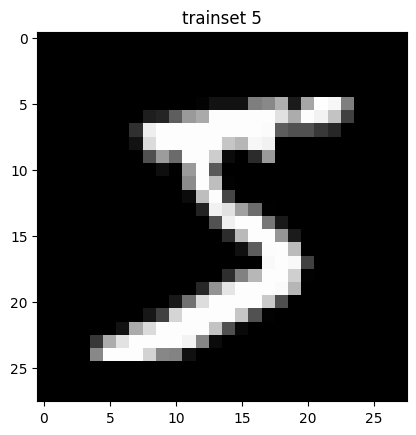

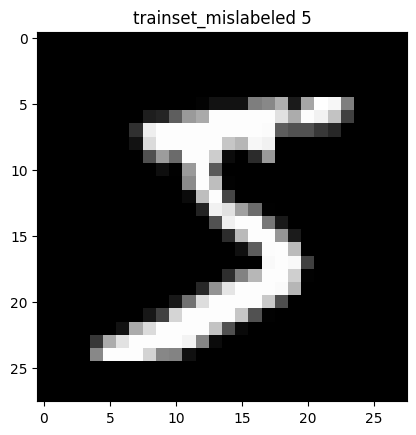

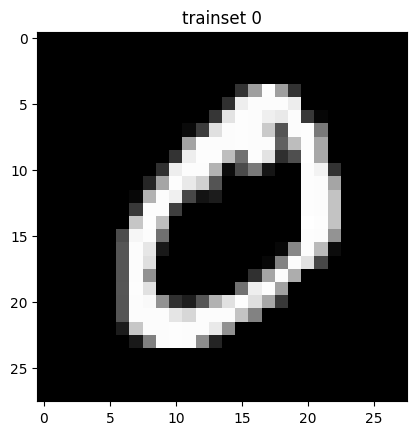

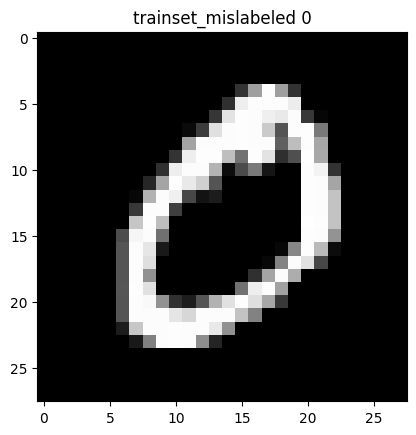

In [13]:
original_dataset_labels = train_data.targets
mislabeled_dataset_true_labels = mislabeled_train_data.true_labels
mislabeled_dataset_labels = mislabeled_train_data.labels

assert((original_dataset_labels == mislabeled_dataset_true_labels).all())
print("percent purposely mislabeled = ", 1 - (mislabeled_dataset_true_labels.numpy() == mislabeled_dataset_labels.numpy()).mean())

(mislabeled_dataset_true_labels.numpy() != mislabeled_dataset_labels.numpy())[:40]
print(np.arange(10), mislabeled_dataset_true_labels.numpy()[:30], mislabeled_dataset_labels.numpy()[:30], sep='\n')
for i in range(2):
  plt.imshow(train_data[i][0].squeeze().numpy(), cmap='gray')
  plt.title('trainset %i' % train_data.targets[i])
  plt.show()

  plt.imshow(mislabeled_train_data[i][0].squeeze().numpy(), cmap='gray')
  plt.title('trainset_mislabeled %i' % mislabeled_train_data.labels[i])
  plt.show()

Dataloader Part Two

In [94]:
loaders_1 = {
    'train' : torch.utils.data.DataLoader(mislabeled_train_data, 
                                          batch_size=100, 
                                          shuffle=False, 
                                          num_workers=0),
    
    
    # 'test'  : torch.utils.data.DataLoader(test_data, ############################### FOR NOW TEST ON TRAIN DATA. NO DATA LEAKAGE!
    #                                       batch_size=100, 
    #                                       shuffle=True, 
    #                                       num_workers=0),

    
    'test' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=0),
}

Model Part 2

In [15]:
cnn_1 = CNN()
print(cnn_1)

loss_func = nn.CrossEntropyLoss()  
optimizer_1 = optim.Adam(cnn_1.parameters(), lr = 0.01) 

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


Model Training Part 2

In [16]:
train(num_epochs, cnn_1, loaders_1, optimizer_1)

Epoch [1/1], Step [100/600], Loss: 0.5552
Epoch [1/1], Step [200/600], Loss: 0.5772
Epoch [1/1], Step [300/600], Loss: 0.6843
Epoch [1/1], Step [400/600], Loss: 0.7443
Epoch [1/1], Step [500/600], Loss: 0.8214
Epoch [1/1], Step [600/600], Loss: 0.5348


In [17]:
test(cnn_1)

Test Accuracy of the model on the 10000 test images: 0.95


(tensor([2, 1, 4, 4, 3, 4, 3, 6, 0, 8, 9, 2, 9, 6, 2, 9, 4, 3, 8, 8, 6, 3, 7, 0,
         3, 0, 7, 0, 4, 3, 4, 7, 6, 2, 3, 4, 5, 3, 6, 9, 9, 4, 5, 0, 4, 6, 6, 6,
         4, 9, 9, 8, 5, 7, 4, 6, 8, 1, 0, 6, 6, 9, 7, 4, 5, 6, 9, 7, 0, 5, 6, 4,
         4, 2, 1, 5, 0, 0, 3, 8, 2, 6, 5, 2, 2, 3, 8, 9, 0, 7, 1, 8, 2, 3, 9, 9,
         7, 5, 7, 1]),
 tensor([[4.9779e-03, 6.7816e-04, 9.6743e-01, 3.0782e-03, 7.8087e-03, 6.7515e-04,
          1.6864e-03, 4.1178e-03, 8.0452e-03, 1.5041e-03],
         [1.5127e-02, 9.3075e-01, 1.0856e-02, 6.8854e-03, 5.3118e-03, 1.0177e-02,
          4.2306e-03, 3.7324e-03, 7.5036e-03, 5.4313e-03],
         [6.5658e-03, 2.7613e-02, 1.5635e-02, 3.0340e-03, 9.0495e-01, 9.3573e-03,
          7.9207e-03, 1.1126e-02, 7.4067e-03, 6.3975e-03],
         [3.1525e-02, 5.6164e-02, 7.9518e-03, 1.3949e-01, 4.5264e-01, 7.3019e-02,
          9.6137e-03, 7.2515e-02, 5.0268e-02, 1.0681e-01],
         [3.0646e-02, 7.9453e-03, 5.6333e-03, 8.9871e-01, 4.0600e-03, 1.0600e-02,
       

In [18]:
sample = next(iter(loaders_1['test']))
imgs, lbls = sample
actual_number = lbls[:10].numpy()
test_output = cnn_1(imgs[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Prediction number: {pred_y}')
print(f'Actual number: {actual_number}')

Prediction number: [3 6 7 2 6 8 2 5 8 2]
Actual number: [3 6 7 2 6 4 2 5 8 2]


Confusion Matrices and Such

<Figure size 640x480 with 0 Axes>

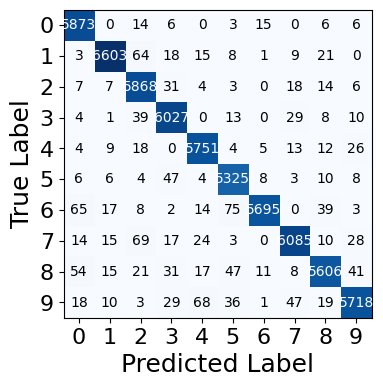

<Figure size 640x480 with 0 Axes>

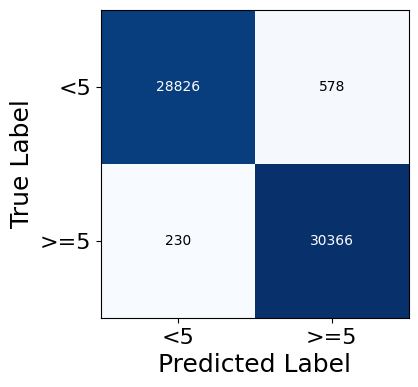

Accuracy of the model is 0.99
Recall of the model is 0.99
Precision of the model is 0.98
F1 Score of the model is 0.99


In [21]:
#Running on test data
cnn_1.to(device)
# preds,labels = test_predict(model, mnist_testLoader)
labels, preds = get_outputs(cnn_1, loaders['test'], device)
# Plot confusion matrix

cm  = confusion_matrix(labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(6,4),cmap=plt.cm.Blues)
plt.xticks(range(10), range(10), fontsize=16)
plt.yticks(range(10), range(10), fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()

# binarize this (for now)
preds = (np.array(preds) < 5)
labels = (np.array(labels) < 5)

cm  = confusion_matrix(labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(6,4),cmap=plt.cm.Blues)
# plt.xticks(range(10), range(10), fontsize=16)
# plt.yticks(range(10), range(10), fontsize=16)
plt.xticks(range(2), ['<5', '>=5'], fontsize=16)
plt.yticks(range(2), ['<5', '>=5'], fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()


# Compute Performance Metrics
tn, fp, fn, tp = cm.ravel()

accuracy_float = (np.array(preds) == np.array(labels)).sum() / len(preds)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*((precision*recall)/(precision+recall))

print("Accuracy of the model is {:.2f}".format(accuracy_float))
print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1 Score of the model is {:.2f}".format(f1))

In [181]:
aled = ALED()
prob_df = aled.fit_predict(model=cnn_1, dataset=mislabeled_train_data, device=device, batch_size=1000, max_pca_variance=0.999999, max_pca_components=32)
# aled.prediction_stats.to_excel("drive/MyDrive/'Colab Notebooks'/MNIST/aled_prediction_stats.xlsx")
aled.prediction_stats[(aled.prediction_stats.iloc[:,:10] > 1).values.any(axis=1)]
aled.prediction_stats.iloc[:,10:]

# When the explained variance gets too high, subsequent principal components are highly correlated, it seems, which may lead to failure in calculating determinant of the covariance matrix. Check this error out.

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
)
feat_array.shape, y.shape: (60000, 32) (60000,)
number of pca components: 9
PCA explained variance: 0.9999998261111528


C:\Users\Small\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-103.664691902687366 > -136.010477300761067). You may want to try with a higher value of support_fraction (current value: 0.503).
  warnings.warn(
C:\Users\Small\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-103.687335600234306 > -137.222503916262667). You may want to try with a higher value of support_fraction (current value: 0.503).
  warnings.warn(
C:\Users\Small\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\skl

,p(k = 0.0 | x),p(k = 1.0 | x),p(k = 2.0 | x),p(k = 3.0 | x),p(k = 4.0 | x),p(k = 5.0 | x),p(k = 6.0 | x),p(k = 7.0 | x),p(k = 8.0 | x),p(k = 9.0 | x),given label (name),out-label
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...
59995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,8.0
59996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0
59997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0
59998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,6.0


In [130]:
posterior_probs_df = aled.prediction_stats.iloc[:,10:]

#label checking
aled_labels = posterior_probs_df["given label (name)"].to_numpy()
dataset_labels = mislabeled_train_data.labels.numpy()
print("The labels in the ALED DF the same as the original dataset:", np.array_equal(aled_labels, dataset_labels))

The labels in the ALED DF the same as the original dataset: True


In [132]:
posterior_probs_df[(posterior_probs_df["given label (name)"] != posterior_probs_df["Aled label"]) & (posterior_probs_df[posterior_probs_df.columns[:-2]] > 0.95).any(1)]

C:\Users\Small\AppData\Local\Temp\ipykernel_27788\880120251.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  posterior_probs_df[(posterior_probs_df["given label (name)"] != posterior_probs_df["out-label"]) & (posterior_probs_df[posterior_probs_df.columns[:-2]] > 0.95).any(1)]


,p(k = 0.0 | x),p(k = 1.0 | x),p(k = 2.0 | x),p(k = 3.0 | x),p(k = 4.0 | x),p(k = 5.0 | x),p(k = 6.0 | x),p(k = 7.0 | x),p(k = 8.0 | x),p(k = 9.0 | x),given label (name),out-label
40,1.269205e-10,9.992463e-01,3.329976e-15,1.030791e-77,1.555483e-05,3.030660e-13,7.378853e-04,1.827494e-08,1.459256e-07,1.453907e-07,5.0,1.0
90,7.435680e-03,1.247559e-05,3.946596e-07,9.415508e-38,3.244248e-02,2.446648e-07,9.570464e-01,3.619377e-04,2.696192e-03,4.186700e-06,5.0,6.0
179,8.849525e-06,1.576918e-126,1.960900e-02,9.537306e-01,2.541323e-08,2.660893e-02,4.611096e-21,4.256230e-05,1.324340e-08,2.938722e-11,4.0,3.0
269,3.950358e-07,9.970011e-01,4.289693e-09,1.657657e-28,2.345170e-04,9.593188e-12,2.617426e-03,1.409982e-04,5.539686e-06,4.317431e-08,3.0,1.0
290,3.399690e-06,9.949026e-01,4.329431e-10,3.975365e-37,1.814730e-04,5.460486e-14,4.883656e-03,2.678546e-05,2.072428e-06,1.108989e-09,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
59706,4.822904e-03,3.483978e-90,9.620180e-01,2.216668e-03,5.096130e-04,2.958561e-03,2.835307e-10,2.744612e-02,1.161535e-05,1.647778e-05,4.0,2.0
59738,4.730511e-07,9.987775e-01,3.994495e-10,1.657689e-31,2.424353e-04,1.371576e-14,7.414240e-04,2.362822e-04,1.854317e-06,5.723574e-09,4.0,1.0
59796,4.237761e-05,9.938361e-01,3.018435e-10,7.425285e-37,5.977230e-04,2.253163e-15,5.382429e-03,1.377870e-04,3.589561e-06,6.470075e-10,9.0,1.0
59958,1.408244e-07,9.990704e-01,4.236850e-10,1.539638e-27,2.323653e-04,2.739273e-13,4.938011e-04,1.998554e-04,3.482036e-06,1.681998e-09,3.0,1.0


In [133]:
roc_labels, pred_probs = get_output_probs(cnn_1, loaders_1["train"], device)
comp_labels, model_labels = get_outputs(cnn_1, loaders_1["train"], device)

Doing the sklearn Stuff

In [134]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(roc_labels)
y_onehot_test = label_binarizer.transform(roc_labels)
class_id = label_binarizer.classes_[0]

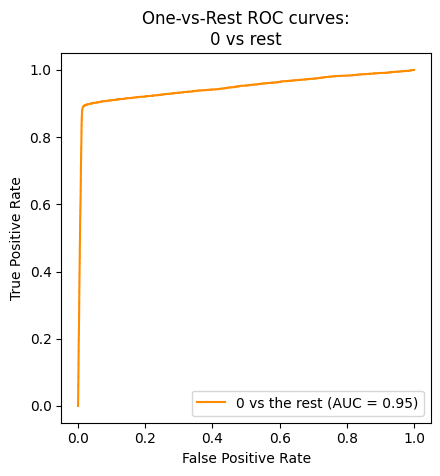

In [135]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    pred_probs[:, class_id],
    name=f"{class_id} vs the rest",
    color="darkorange",
    #plot_chance_level=True,
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\n{} vs rest".format(class_id))
plt.legend()
plt.show()

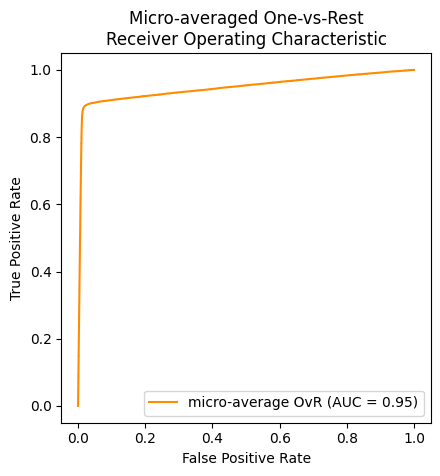

In [136]:
RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    pred_probs.ravel(),
    name="micro-average OvR",
    color="darkorange",
    #plot_chance_level=True,
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

In [137]:
def find_best_F1(y, x, ret=False):
  # ret determines whether to return or print best F1 and threshold
  print("AUC:", sklearn.metrics.roc_auc_score(y, x))
  precisions, recalls, thresholds = sklearn.metrics.precision_recall_curve(y, x)
  f1_scores = 2*precisions*recalls/(precisions+recalls)
  # f1_scores = 2/(1/precisions + 1/recalls)
  best_F1 = np.nanmax(f1_scores)
  best_F1_threshold = thresholds[np.nanargmax(f1_scores)]
  if not ret:
    print(f"Best F1 score: {best_F1}; threshold: {best_F1_threshold}")
    #print_classification_report(y, x>=best_F1_threshold)
  else: return best_F1, best_F1_threshold

find_best_F1(y_onehot_test.ravel(), pred_probs.ravel())

AUC: 0.9474720184104939
Best F1 score: 0.8780678938241964; threshold: 0.3195878565311432


In [143]:
posterior_probs_df["model pred labels"] = model_labels

C:\Users\Small\AppData\Local\Temp\ipykernel_27788\1697124016.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posterior_probs_df["model pred labels"] = model_labels


In [144]:
posterior_probs_df["true labels"] = mislabeled_train_data.true_labels

C:\Users\Small\AppData\Local\Temp\ipykernel_27788\3860588679.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posterior_probs_df["true labels"] = mislabeled_train_data.true_labels


In [145]:
posterior_probs_df

,p(k = 0.0 | x),p(k = 1.0 | x),p(k = 2.0 | x),p(k = 3.0 | x),p(k = 4.0 | x),p(k = 5.0 | x),p(k = 6.0 | x),p(k = 7.0 | x),p(k = 8.0 | x),p(k = 9.0 | x),given label (name),out-label,model pred labels,true labels
0,3.994484e-06,1.425344e-88,4.525460e-02,2.914956e-02,5.087696e-07,9.254864e-01,1.868124e-17,9.750478e-05,7.416739e-06,3.664137e-08,5.0,5.0,5,5
1,8.894261e-01,3.289228e-24,2.945764e-07,1.552987e-42,1.534656e-02,4.241667e-09,9.503997e-02,1.042224e-07,1.869386e-04,6.980511e-13,0.0,0.0,0,0
2,2.587006e-02,8.648416e-27,5.024709e-02,4.228416e-10,3.615738e-01,1.877209e-02,2.180250e-02,1.476694e-02,4.996565e-01,7.311073e-03,4.0,4.0,4,4
3,5.619604e-07,9.997735e-01,6.832654e-12,7.724481e-37,3.312210e-05,2.502205e-18,1.790781e-04,1.362546e-05,8.083372e-08,1.896149e-11,1.0,1.0,1,1
4,1.821214e-04,1.909752e-35,1.766941e-02,1.157720e-14,6.992237e-03,1.745821e-05,7.405138e-04,2.518708e-03,9.810380e-02,8.737758e-01,9.0,9.0,9,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,1.246863e-04,1.056369e-11,1.314167e-03,3.912042e-13,1.264216e-01,7.595670e-04,9.316682e-02,9.239334e-02,3.098150e-01,3.760048e-01,8.0,8.0,8,8
59996,4.190393e-05,1.673895e-94,3.168869e-02,9.271175e-01,1.605972e-06,4.071756e-02,6.017904e-16,4.321706e-04,5.456811e-07,1.806257e-08,3.0,3.0,3,3
59997,2.468189e-03,2.164803e-61,1.190551e-01,2.497795e-03,2.562898e-04,8.737391e-01,3.824165e-09,9.989200e-04,9.843031e-04,3.199554e-07,5.0,5.0,5,5
59998,1.565787e-01,7.656495e-36,1.814124e-02,1.257741e-16,5.833353e-01,3.829435e-04,5.166533e-02,3.965610e-03,1.716500e-01,1.428087e-02,6.0,4.0,6,6


In [147]:
checking_df = posterior_probs_df[(posterior_probs_df["given label (name)"] != posterior_probs_df["true labels"])]
checking_df[(checking_df["Aled label"] == checking_df["true labels"]) & (checking_df["model pred labels"] != checking_df["true labels"])]

,p(k = 0.0 | x),p(k = 1.0 | x),p(k = 2.0 | x),p(k = 3.0 | x),p(k = 4.0 | x),p(k = 5.0 | x),p(k = 6.0 | x),p(k = 7.0 | x),p(k = 8.0 | x),p(k = 9.0 | x),given label (name),out-label,model pred labels,true labels
11992,1.039513e-06,6.935316e-07,3.080565e-04,1.170538e-14,0.111587,3.986384e-04,6.199272e-02,0.046513,2.791149e-01,5.000843e-01,4.0,9.0,1,9
14337,1.805431e-05,3.072395e-33,3.070499e-02,2.642737e-02,0.020466,8.438086e-03,4.961216e-05,0.723785,2.998202e-03,1.871127e-01,5.0,7.0,2,7
14664,2.491910e-02,1.219756e-47,7.250838e-02,2.722183e-16,0.226033,8.335077e-02,1.919278e-06,0.249660,3.348941e-01,8.632665e-03,5.0,8.0,6,8
15717,3.634307e-07,6.736700e-57,1.094892e-02,8.740681e-01,0.000033,1.145622e-01,1.488690e-12,0.000377,3.774981e-06,7.161682e-06,4.0,3.0,2,3
17808,4.031571e-02,4.669940e-32,6.675146e-02,1.859561e-11,0.339874,1.012110e-03,4.284974e-02,0.002925,4.713122e-01,3.495965e-02,5.0,8.0,3,8
19869,2.492650e-03,3.382537e-81,2.137535e-01,9.358438e-04,0.001480,8.555048e-03,5.276236e-09,0.771206,8.358617e-06,1.568560e-03,4.0,7.0,3,7
20735,3.401115e-03,1.059652e-18,1.232106e-03,1.223090e-18,0.127192,2.609534e-04,4.070321e-02,0.070766,3.147084e-01,4.417359e-01,2.0,9.0,0,9
21918,3.945002e-02,2.391628e-08,1.812536e-09,2.921429e-57,0.047504,1.295940e-08,9.124566e-01,0.000011,5.761666e-04,1.885472e-06,9.0,6.0,0,6
21982,9.127342e-04,1.012957e-108,8.664255e-01,1.913276e-02,0.000016,1.090601e-01,3.613939e-17,0.004435,1.816087e-05,4.686668e-09,4.0,2.0,7,2
22212,2.117998e-03,6.361477e-03,6.586160e-06,7.067651e-22,0.242389,2.619279e-07,6.581885e-01,0.051691,3.921890e-02,2.630647e-05,4.0,6.0,1,6


In [148]:
checking_df[(checking_df["given label (name)"] != checking_df["true labels"]) & (checking_df["Aled label"] != checking_df["given label (name)"])]

,p(k = 0.0 | x),p(k = 1.0 | x),p(k = 2.0 | x),p(k = 3.0 | x),p(k = 4.0 | x),p(k = 5.0 | x),p(k = 6.0 | x),p(k = 7.0 | x),p(k = 8.0 | x),p(k = 9.0 | x),given label (name),out-label,model pred labels,true labels
12,2.734830e-04,2.495620e-113,2.132880e-01,7.759419e-01,0.000003,9.576285e-03,6.348387e-17,0.000917,4.065776e-07,9.245935e-10,4.0,3.0,3,3
17,1.308090e-04,2.158752e-15,4.388864e-05,7.469825e-19,0.082615,8.368808e-07,3.925786e-02,0.000032,8.778078e-01,1.115197e-04,3.0,8.0,8,8
20,7.609320e-01,4.981734e-68,4.772575e-03,6.383826e-28,0.169279,4.186479e-02,4.024867e-06,0.009329,1.087438e-02,2.944740e-03,9.0,0.0,4,4
28,3.369060e-04,1.481799e-128,7.856074e-01,2.098135e-01,0.000004,4.672926e-05,1.176075e-15,0.004192,8.170328e-09,2.272453e-09,9.0,2.0,2,2
33,6.386463e-07,4.640152e-21,2.361626e-04,6.320194e-10,0.004917,5.568385e-05,3.948409e-04,0.115501,2.469831e-02,8.541958e-01,4.0,9.0,9,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59958,1.408244e-07,9.990704e-01,4.236850e-10,1.539638e-27,0.000232,2.739273e-13,4.938011e-04,0.000200,3.482036e-06,1.681998e-09,3.0,1.0,1,1
59960,5.479534e-08,6.263755e-66,1.240379e-02,3.109172e-01,0.000002,6.766610e-01,3.725526e-15,0.000013,6.940118e-07,1.667069e-06,0.0,5.0,5,5
59968,3.336922e-05,1.635882e-75,8.050663e-02,4.099218e-02,0.000019,8.760280e-01,3.074661e-13,0.002390,1.900567e-05,1.146985e-05,1.0,5.0,5,5
59981,8.356487e-05,3.329801e-14,6.464941e-04,4.701677e-10,0.122039,3.749115e-04,2.570520e-02,0.425806,7.641504e-02,3.489294e-01,5.0,7.0,6,6


In [149]:
checking_df[(checking_df["model pred labels"] != checking_df["given label (name)"])]

,p(k = 0.0 | x),p(k = 1.0 | x),p(k = 2.0 | x),p(k = 3.0 | x),p(k = 4.0 | x),p(k = 5.0 | x),p(k = 6.0 | x),p(k = 7.0 | x),p(k = 8.0 | x),p(k = 9.0 | x),given label (name),out-label,model pred labels,true labels
11,1.313415e-06,1.448515e-38,7.883591e-03,7.713772e-01,0.000969,2.175485e-01,4.063427e-09,0.001703,3.174048e-04,2.002388e-04,3.0,3.0,5,5
12,2.734830e-04,2.495620e-113,2.132880e-01,7.759419e-01,0.000003,9.576285e-03,6.348387e-17,0.000917,4.065776e-07,9.245935e-10,4.0,3.0,3,3
17,1.308090e-04,2.158752e-15,4.388864e-05,7.469825e-19,0.082615,8.368808e-07,3.925786e-02,0.000032,8.778078e-01,1.115197e-04,3.0,8.0,8,8
20,7.609320e-01,4.981734e-68,4.772575e-03,6.383826e-28,0.169279,4.186479e-02,4.024867e-06,0.009329,1.087438e-02,2.944740e-03,9.0,0.0,4,4
28,3.369060e-04,1.481799e-128,7.856074e-01,2.098135e-01,0.000004,4.672926e-05,1.176075e-15,0.004192,8.170328e-09,2.272453e-09,9.0,2.0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59958,1.408244e-07,9.990704e-01,4.236850e-10,1.539638e-27,0.000232,2.739273e-13,4.938011e-04,0.000200,3.482036e-06,1.681998e-09,3.0,1.0,1,1
59960,5.479534e-08,6.263755e-66,1.240379e-02,3.109172e-01,0.000002,6.766610e-01,3.725526e-15,0.000013,6.940118e-07,1.667069e-06,0.0,5.0,5,5
59968,3.336922e-05,1.635882e-75,8.050663e-02,4.099218e-02,0.000019,8.760280e-01,3.074661e-13,0.002390,1.900567e-05,1.146985e-05,1.0,5.0,5,5
59981,8.356487e-05,3.329801e-14,6.464941e-04,4.701677e-10,0.122039,3.749115e-04,2.570520e-02,0.425806,7.641504e-02,3.489294e-01,5.0,7.0,6,6


In [150]:
checking_df[(checking_df["model pred labels"] == checking_df["true labels"])]

,p(k = 0.0 | x),p(k = 1.0 | x),p(k = 2.0 | x),p(k = 3.0 | x),p(k = 4.0 | x),p(k = 5.0 | x),p(k = 6.0 | x),p(k = 7.0 | x),p(k = 8.0 | x),p(k = 9.0 | x),given label (name),out-label,model pred labels,true labels
11,1.313415e-06,1.448515e-38,7.883591e-03,7.713772e-01,0.000969,2.175485e-01,4.063427e-09,0.001703,3.174048e-04,2.002388e-04,3.0,3.0,5,5
12,2.734830e-04,2.495620e-113,2.132880e-01,7.759419e-01,0.000003,9.576285e-03,6.348387e-17,0.000917,4.065776e-07,9.245935e-10,4.0,3.0,3,3
17,1.308090e-04,2.158752e-15,4.388864e-05,7.469825e-19,0.082615,8.368808e-07,3.925786e-02,0.000032,8.778078e-01,1.115197e-04,3.0,8.0,8,8
20,7.609320e-01,4.981734e-68,4.772575e-03,6.383826e-28,0.169279,4.186479e-02,4.024867e-06,0.009329,1.087438e-02,2.944740e-03,9.0,0.0,4,4
28,3.369060e-04,1.481799e-128,7.856074e-01,2.098135e-01,0.000004,4.672926e-05,1.176075e-15,0.004192,8.170328e-09,2.272453e-09,9.0,2.0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59958,1.408244e-07,9.990704e-01,4.236850e-10,1.539638e-27,0.000232,2.739273e-13,4.938011e-04,0.000200,3.482036e-06,1.681998e-09,3.0,1.0,1,1
59960,5.479534e-08,6.263755e-66,1.240379e-02,3.109172e-01,0.000002,6.766610e-01,3.725526e-15,0.000013,6.940118e-07,1.667069e-06,0.0,5.0,5,5
59968,3.336922e-05,1.635882e-75,8.050663e-02,4.099218e-02,0.000019,8.760280e-01,3.074661e-13,0.002390,1.900567e-05,1.146985e-05,1.0,5.0,5,5
59981,8.356487e-05,3.329801e-14,6.464941e-04,4.701677e-10,0.122039,3.749115e-04,2.570520e-02,0.425806,7.641504e-02,3.489294e-01,5.0,7.0,6,6


In [151]:
posterior_probs_df[posterior_probs_df["model pred labels"] == posterior_probs_df["true labels"]]

,p(k = 0.0 | x),p(k = 1.0 | x),p(k = 2.0 | x),p(k = 3.0 | x),p(k = 4.0 | x),p(k = 5.0 | x),p(k = 6.0 | x),p(k = 7.0 | x),p(k = 8.0 | x),p(k = 9.0 | x),given label (name),out-label,model pred labels,true labels
0,3.994484e-06,1.425344e-88,4.525460e-02,2.914956e-02,5.087696e-07,9.254864e-01,1.868124e-17,9.750478e-05,7.416739e-06,3.664137e-08,5.0,5.0,5,5
1,8.894261e-01,3.289228e-24,2.945764e-07,1.552987e-42,1.534656e-02,4.241667e-09,9.503997e-02,1.042224e-07,1.869386e-04,6.980511e-13,0.0,0.0,0,0
2,2.587006e-02,8.648416e-27,5.024709e-02,4.228416e-10,3.615738e-01,1.877209e-02,2.180250e-02,1.476694e-02,4.996565e-01,7.311073e-03,4.0,4.0,4,4
3,5.619604e-07,9.997735e-01,6.832654e-12,7.724481e-37,3.312210e-05,2.502205e-18,1.790781e-04,1.362546e-05,8.083372e-08,1.896149e-11,1.0,1.0,1,1
4,1.821214e-04,1.909752e-35,1.766941e-02,1.157720e-14,6.992237e-03,1.745821e-05,7.405138e-04,2.518708e-03,9.810380e-02,8.737758e-01,9.0,9.0,9,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,1.246863e-04,1.056369e-11,1.314167e-03,3.912042e-13,1.264216e-01,7.595670e-04,9.316682e-02,9.239334e-02,3.098150e-01,3.760048e-01,8.0,8.0,8,8
59996,4.190393e-05,1.673895e-94,3.168869e-02,9.271175e-01,1.605972e-06,4.071756e-02,6.017904e-16,4.321706e-04,5.456811e-07,1.806257e-08,3.0,3.0,3,3
59997,2.468189e-03,2.164803e-61,1.190551e-01,2.497795e-03,2.562898e-04,8.737391e-01,3.824165e-09,9.989200e-04,9.843031e-04,3.199554e-07,5.0,5.0,5,5
59998,1.565787e-01,7.656495e-36,1.814124e-02,1.257741e-16,5.833353e-01,3.829435e-04,5.166533e-02,3.965610e-03,1.716500e-01,1.428087e-02,6.0,4.0,6,6


In [152]:
posterior_probs_df[(posterior_probs_df["Aled label"] != posterior_probs_df["given label (name)"]) & (posterior_probs_df["given label (name)"] == posterior_probs_df["true labels"])]

,p(k = 0.0 | x),p(k = 1.0 | x),p(k = 2.0 | x),p(k = 3.0 | x),p(k = 4.0 | x),p(k = 5.0 | x),p(k = 6.0 | x),p(k = 7.0 | x),p(k = 8.0 | x),p(k = 9.0 | x),given label (name),out-label,model pred labels,true labels
5,5.738387e-05,2.188596e-89,0.097686,8.994777e-01,1.554034e-05,0.000824,2.197961e-14,0.001939,9.429386e-07,4.021167e-08,2.0,3.0,2,2
18,8.412664e-04,2.464885e-19,0.004320,3.936592e-10,2.909750e-01,0.000833,2.206852e-02,0.002138,6.777124e-01,1.112020e-03,6.0,8.0,6,6
24,4.262939e-04,5.570471e-62,0.104290,7.821591e-01,5.878870e-04,0.092843,6.523039e-10,0.019539,1.086663e-04,4.639350e-05,1.0,3.0,2,1
29,6.747888e-08,4.613171e-27,0.005647,9.044125e-01,4.000819e-03,0.036459,1.976344e-06,0.042549,1.602044e-04,6.769759e-03,7.0,3.0,7,7
31,2.454744e-02,7.266596e-16,0.000902,9.829198e-19,3.693660e-01,0.000219,2.512173e-01,0.131444,1.503722e-01,7.193147e-02,8.0,4.0,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59983,5.598403e-05,2.588437e-111,0.107872,8.905200e-01,1.315930e-06,0.001008,8.602708e-18,0.000542,9.534556e-08,3.541492e-10,2.0,3.0,2,2
59985,3.988798e-05,1.222788e-117,0.067728,2.808243e-01,3.299403e-08,0.651402,6.174675e-19,0.000006,3.224836e-07,1.450772e-12,2.0,5.0,2,2
59988,1.558823e-04,1.079368e-31,0.056512,3.807482e-01,5.806706e-02,0.297612,1.142505e-05,0.179596,8.990364e-03,1.830745e-02,7.0,3.0,7,7
59998,1.565787e-01,7.656495e-36,0.018141,1.257741e-16,5.833353e-01,0.000383,5.166533e-02,0.003966,1.716500e-01,1.428087e-02,6.0,4.0,6,6


In [124]:
aled.pca_explained_variance

0.6142588084777116

In [125]:
aled.num_pca_components

2

AUC: 0.9420924135802469
Threshold for best F1: 0.9932597320484021


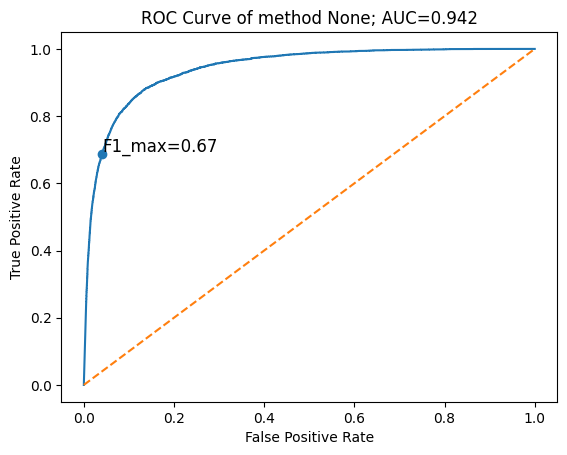

In [169]:
def plot_ROC(df_Y, df_X, title=None, plot_f1_max=True):
  fpr, tpr, thresholds = sklearn.metrics.roc_curve(df_Y, df_X)
  # print(thresholds)
  auc = sklearn.metrics.roc_auc_score(df_Y, df_X)
  plt.plot(fpr, tpr, scaley=False, scalex=False)
  plt.plot((0,1), linestyle='dashed')
  plt.title(f"ROC Curve of method {title}; AUC={auc:.3f}")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")

  # plot max f1
  if plot_f1_max:
    f1_max, threshold_f1_max = find_best_F1(df_Y, df_X, ret=True)
    print("Threshold for best F1:", threshold_f1_max)
    fpr_f1_max, tpr_f1_max = fpr[thresholds==threshold_f1_max], tpr[thresholds==threshold_f1_max]
    plt.scatter(fpr_f1_max, tpr_f1_max)
    plt.text(fpr_f1_max * (1 + 0.01), tpr_f1_max * (1 + 0.01) , f'F1_max={f1_max:.2f}', fontsize=12)

  plt.show()

plot_ROC(posterior_probs_df["given label (name)"] != posterior_probs_df["true labels"], 1 - posterior_probs_df.apply(lambda row: row.iloc[int(row["given label (name)"])], axis=1).to_numpy())

AUC: 0.8376455370370371
Threshold for best F1: 640.5018280590868


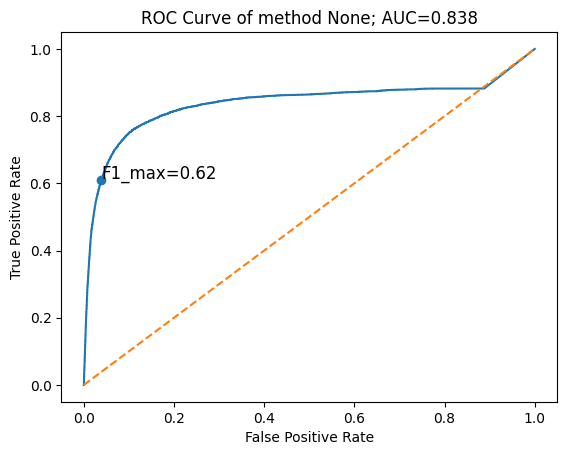

In [170]:
plot_ROC(posterior_probs_df["given label (name)"] != posterior_probs_df["true labels"], posterior_probs_df.apply(lambda row: row.iloc[:10].argmax() / row.iloc[int(row["given label (name)"])], axis=1).to_numpy())

In [179]:
posterior_probs_df[(posterior_probs_df["given label (name)"] == posterior_probs_df["true labels"]) & (posterior_probs_df[posterior_probs_df.columns[:-4]] > 0.95).any(1) & (posterior_probs_df["out-label"] != posterior_probs_df["true labels"])]

C:\Users\Small\AppData\Local\Temp\ipykernel_27788\2751278478.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  posterior_probs_df[(posterior_probs_df["given label (name)"] == posterior_probs_df["true labels"]) & (posterior_probs_df[posterior_probs_df.columns[:-4]] > 0.95).any(1) & (posterior_probs_df["out-label"] != posterior_probs_df["true labels"])]


,p(k = 0.0 | x),p(k = 1.0 | x),p(k = 2.0 | x),p(k = 3.0 | x),p(k = 4.0 | x),p(k = 5.0 | x),p(k = 6.0 | x),p(k = 7.0 | x),p(k = 8.0 | x),p(k = 9.0 | x),given label (name),out-label,model pred labels,true labels
1023,1.955426e-08,1.933588e-33,5.575818e-03,9.540141e-01,8.956306e-04,1.217764e-02,2.786154e-07,2.615120e-02,3.179590e-05,1.153464e-03,7.0,3.0,7,7
1075,1.534290e-07,6.691055e-51,1.189811e-02,9.683299e-01,1.097713e-04,1.592452e-02,4.240165e-10,3.710179e-03,2.943747e-06,2.440332e-05,7.0,3.0,7,7
1119,1.453660e-05,4.448264e-69,1.695074e-02,6.212534e-03,1.982746e-06,9.765995e-01,4.207030e-13,1.973741e-04,2.244042e-05,9.238985e-07,3.0,5.0,3,3
1143,2.248206e-03,2.983601e-67,1.658622e-02,1.855184e-10,1.384626e-04,9.800644e-01,1.716995e-09,3.978766e-04,5.645939e-04,2.209910e-07,2.0,5.0,2,2
1324,1.554939e-02,7.185461e-108,9.834119e-01,8.754339e-06,2.712940e-04,6.644191e-04,9.478339e-13,7.404420e-05,2.015312e-05,2.234518e-09,5.0,2.0,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58259,9.506230e-01,3.919347e-19,1.088429e-08,4.776678e-53,3.097477e-02,2.055323e-10,1.809941e-02,1.982444e-07,3.025693e-04,3.685223e-10,6.0,0.0,6,6
58495,4.423375e-06,5.245683e-135,3.093217e-02,6.584733e-04,1.874732e-09,9.684046e-01,2.150363e-21,1.501662e-07,1.613687e-07,1.208344e-15,3.0,5.0,3,3
58817,1.357521e-02,1.354575e-85,9.825699e-01,1.621915e-05,3.035202e-03,7.263820e-06,3.056801e-09,2.781761e-06,7.933780e-04,5.793771e-09,8.0,2.0,8,8
59239,1.928676e-05,1.475646e-72,3.403805e-02,4.186966e-03,8.013416e-06,9.607569e-01,2.397849e-13,9.600860e-04,2.715815e-05,3.586618e-06,3.0,5.0,3,3
